# Imports & Setup

In [1]:
# !pip install ydata-profiling
# !pip install ipywidgets # needed for ProfileReport

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import gc
from time import perf_counter 
from tqdm import tqdm

import string
import re

import itertools
from itertools import permutations, product, combinations
from functools import reduce

import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Optional
from ydata_profiling import ProfileReport
import ipywidgets

## Load Data

In [13]:
train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')
sample_solution = pd.read_csv("data/BBC News Sample Solution.csv")

# EDA
- Visualize the raw data of the training set by:
    - Viewing the individual records
    - View the information about the dataset
    - Creating a histogram to visualize the data
    - Develop a conclusion about the data

- Findings from below:
    - There are 1490 news grouped into 5 topics
    - There are no null/nan/missing values
    - Classes are relatively balanced. 
    - The most common and least common topics are sports and entertainment respectively.
    - There are 50 non-unique articles from `train.nunique()`
    - After tokenizing the document, the maximum, minimum, and average amount of words in each article are (1698, 48, 219.71744966442952)

In [14]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [16]:
train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

Find the number of words per article

In [27]:
train['Num_Words'] = train['Text'].apply(lambda x: len(x.split()))

max_words = train['Num_Words'].max()
min_words = train['Num_Words'].min()
avg_words = train['Num_Words'].mean()

print(f"Max words: {max_words}\nMin words: {min_words},\nAvg words: {avg_words}")

Max words: 3345
Min words: 90,
Avg words: 385.01275167785235


In [19]:
max(train['Text'].value_counts())

2

Display the number of articles per topic

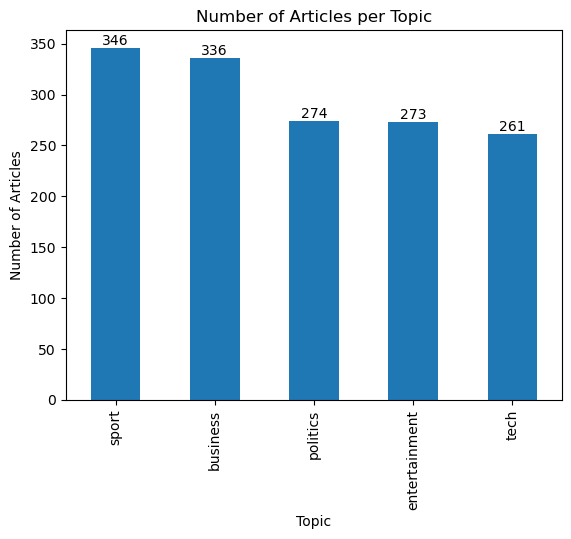

In [6]:
%matplotlib inline

train['Category'].value_counts().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Topic')

plt.xticks(rotation=90)

for i, v in enumerate(train['Category'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

Drop any duplicates:

In [7]:
train = train.drop_duplicates(subset=['Text'], ignore_index=True)

Create a profile report after removing stop words

In [9]:
profile = ProfileReport(train, title="Test Profiling Report") #, explorative=True)
profile.to_notebook_iframe()
profile.to_file("test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.10/site-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Create the labels

In [29]:
labels = dict(zip(train['Category'].unique().tolist(), list(range(5))))
labels

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [30]:
train['Label'] = [labels[l] for l in train['Category']]
train.tail()

,ArticleId,Text,Category,Num_Words,Label
1485,857,double eviction from big brother model caprice...,entertainment,223,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,558,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,237,0
1488,1587,apple ipod family expands market apple has exp...,tech,560,1
1489,538,santy worm makes unwelcome visit thousands of ...,tech,295,1


In [32]:
y_labels = train['Label'].tolist()

# Create Embeddings
Using `TfidfVectorizer`, we will create the embeddings that turns natural language into vectors (numbers)

Tokenize and create the datasets using tfidf to train the NMF model

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", lowercase = True)
tfidf_vectorizer.fit(train['Text'])
tfidf_valid = tfidf_vectorizer.transform(X_valid)
tokens = tfidf_vectorizer.get_feature_names_out()
train_vect = pd.DataFrame(data = tfidf_train.toarray(),columns = tokens)
valid_vect = pd.DataFrame(data = tfidf_valid.toarray(),columns = tokens)

In [15]:
tfidf_train, tfidf_valid, train_vect, valid_vect = tfidf(X_train, X_valid)

# Model Construction
Use [`sklearn.decomposition.NMF`]('https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html') to construct an NMF model. 

Tune hyperparameters by changing loss function and solver to find the best combination.

Steps:
- Define the model (to keep the params the same, create a function to pass the beta_loss and solver into `NMF`)
- Define a predict method 
- Define label permute (returns permuted label order and accuracy)

In [30]:
def model(n_components, beta_loss, solver, alpha_w, alpha_h):
    nmf = NMF(
        init='nndsvdar', # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization: better for sparsenes
        n_components=n_components, # n_components='auto' will return an error
        solver=solver,
        random_state=1,
        beta_loss=beta_loss,
        alpha_W=alpha_w,
        alpha_H=alpha_h,
        l1_ratio=.1,
    )
    return nmf

Create a predict method:

In [17]:
def predict(matrix):
    sortedMatrix = np.argsort(matrix)
    n_predictions, maxValue = sortedMatrix.shape
    
    predictions = [[sortedMatrix[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

Calculate the accuracy based on the best permutation of categories:

In [18]:
def label_permute(ytdf, yp, perm_list):
    unique = np.unique(ytdf)
    perm = itertools.permutations(perm_list)
    accuracy_matrix = []
    for i in list(perm):
        j = 0
        ytdf_guess = ytdf
        for k in unique:
            ytdf_guess = np.where(ytdf_guess == k, i[j], ytdf_guess)
            j+=1
        pred = ytdf_guess.tolist()

        accuracy = accuracy_score(pred,yp)
        accuracy_matrix.append((i,accuracy))
    i = 0
    max_accuracy = 0
    while i < len(accuracy_matrix):
        if accuracy_matrix[i][1] > max_accuracy:
            max_accuracy = accuracy_matrix[i][1]
        i += 1
    
    return max_accuracy

In [19]:
labels = [0,1,2,3,4]

Find the best combination of beta_loss and solver:

In [20]:
# Define the combinations of beta_loss and solver
combinations = [('kullback-leibler', 'mu'), ('frobenius', 'cd'), ('frobenius', 'mu')]

# Create an empty dictionary to store the training scores
training_scores = {}

# Iterate over each combination
for beta_loss, solver in combinations:
    # Create the model with the specified beta_loss and solver
    m = model(beta_loss, solver).fit(tfidf_train)
    yhat = predict(m.transform(tfidf_train))
    
    # Calculate the training scores using label_permute
    accuracy = label_permute(y_train, yhat, labels)
    
    # Store the scores in the dictionary
    training_scores[(beta_loss, solver)] = accuracy

# Print the training scores
for combination, score in training_scores.items():
    print(f"Combination: {combination}, Training Score: {score}")


Combination: ('kullback-leibler', 'mu'), Training Score: 0.950207468879668
Combination: ('frobenius', 'cd'), Training Score: 0.9056016597510373
Combination: ('frobenius', 'mu'), Training Score: 0.8962655601659751


Since the best combination is 'kullback-leibler'-'mu', we will use that on the validation data

In [21]:
beta_loss, solver = max(training_scores, key=lambda x: training_scores[x])

final_model = model(beta_loss, solver).fit(tfidf_train)
yhat = predict(final_model.transform(tfidf_valid))
accuracy = label_permute(y_valid, yhat,labels)

print(accuracy)

0.9642857142857143


# Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_components': [3, 5, 7],
    'beta_loss': ['kullback-leibler', 'frobenius'],
    'solver': ['mu', 'cd'],
    'alpha_W':[0.00005, 0.0005, 0.005, 0.05, 0.5],
    'alpha_H':[0.00005, 0.0005, 0.005, 0.05, 0.5],
}

# Create an instance of the model
m = NMF(init='nndsvdar', random_state=1, l1_ratio=.1)

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(tfidf_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = NMF(**best_params)
best_model.fit(tfidf_train)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
  warnings.warn(


NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', n_components=3,
    solver='mu')

In [32]:
print(best_params['n_components'])

3


In [35]:
nmf = NMF(
    init='nndsvdar', # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization: better for sparsenes
    n_components=best_params['n_components'], # n_components='auto' will return an error
    solver=best_params['solver'],
    random_state=1,
    beta_loss=best_params['beta_loss'],
    alpha_W=best_params['alpha_W'],
    alpha_H=best_params['alpha_H'],
    l1_ratio=.1,
)

nmf.fit(tfidf_train)

NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', init='nndsvdar',
    l1_ratio=0.1, n_components=3, random_state=1, solver='mu')

In [28]:
# Validate the model with the best hyperparameters
best_model = NMF(**best_params)
best_model.fit(tfidf_valid)

NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', n_components=3,
    solver='mu')

# Supervised Learning Comparison: Random Forest

In [30]:
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Fit the Random Forest to the training data
rf.fit(tfidf_train, y_train)

# Make predictions on the validation data
y_pred = rf.predict(tfidf_valid)

# Calculate the accuracy of the Random Forest
accuracy = accuracy_score(y_valid, y_pred)
print("Random Forest Accuracy: ", accuracy)

Random Forest Accuracy:  0.9613821138211383
